In [1]:
# --- Imports ---
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random


from auction import Auction
from player import RangePlayer

# Ensure plots render inline
%matplotlib inline


In [ ]:
# --- Simulation Configuration ---

EPSILON = 0.00001

slow_speed = (0.0, 0.4)
slow_mean = 0.7
fast_mean = 0.7  # fixed to isolate speed effect

starts = np.linspace(0, 0.7, 100)
fast_speed_ranges = [(round(start, 3), round(start + 0.3, 3)) for start in starts]

num_slow = 1
num_fast = 1
num_rounds = 10000
bid_range_width = 0.1


In [3]:
# --- Run Simulations ---

def safe_divide(a, b):
    return a / (b + 1e-9)

def compute_profits(player_ids, profits, submit_bys, cutoff_time, winner):
    for pid in player_ids:
        if submit_bys[pid] < cutoff_time:
            if winner and pid == winner[0]:
                profits.append(winner[2])
            else:
                profits.append(0.0)

results = []

for fast_speed in fast_speed_ranges:
    players = []

    # Create slow (non-reactive) players
    for i in range(num_slow):
        lo = random.uniform(*slow_speed)
        hi = random.uniform(*slow_speed)
        speed = (min(lo, hi), max(lo, hi))

        bid_range = (
            slow_mean,
            bid_range_width
        )
        players.append(RangePlayer(i, speed, bid_range, reactive=False))

    # Create fast (reactive) players
    for i in range(num_slow, num_slow + num_fast):
        lo = random.uniform(*fast_speed)
        hi = random.uniform(*fast_speed)
        speed = (min(lo, hi), max(lo, hi))
        bid_range = (
            fast_mean,
            bid_range_width
        )
        players.append(RangePlayer(i, speed, bid_range, reactive=True))

    auction = Auction(players, cutoff_time_range=(0.6, 0.7 - EPSILON), sealed_bids=False)
    round_results, winnings = auction.run_simulation(num_rounds)

    fast_ids = [p.player_id for p in players if p.reactive]
    slow_ids = [p.player_id for p in players if not p.reactive]

    fast_profits = []
    slow_profits = []

    for r in round_results:
        cutoff_time = r["cutoff_time"]
        submit_bys = r["submit_bys"]
        winner = r["winner"]

        compute_profits(fast_ids, fast_profits, submit_bys, cutoff_time, winner)
        compute_profits(slow_ids, slow_profits, submit_bys, cutoff_time, winner)


    fast_wins = sum(1 for r in round_results
                    if r['winner'] and r['winner'][0] in fast_ids and
                    r["submit_bys"][r['winner'][0]] < r["cutoff_time"])

    slow_wins = sum(1 for r in round_results
                    if r['winner'] and r['winner'][0] in slow_ids and
                    r["submit_bys"][r['winner'][0]] < r["cutoff_time"])


    total_fast_bids = total_fast_missed = total_slow_bids = total_slow_missed = 0
    for r in round_results:
        cutoff = r["cutoff_time"]
        submit_bys = r["submit_bys"]
        for pid in fast_ids:
            if submit_bys[pid] >= cutoff:
                total_fast_missed += 1
            total_fast_bids += 1
        for pid in slow_ids:
            if submit_bys[pid] >= cutoff:
                total_slow_missed += 1
            total_slow_bids += 1

    fast_valid_bids = total_fast_bids - total_fast_missed
    slow_valid_bids = total_slow_bids - total_slow_missed

    results.append({
        "fast_speed_range": fast_speed,
        "fast_max_speed": fast_speed[1],
        "slow_total_profit": round(sum(slow_profits), 5),
        "slow_win_rate": round(slow_wins / num_rounds, 5),
        "fast_total_profit": round(sum(fast_profits), 5),
        "fast_win_rate": round(fast_wins / num_rounds, 5),
        "fast_miss_rate": round(total_fast_missed / total_fast_bids, 5),
        "slow_miss_rate": round(total_slow_missed / total_slow_bids, 5),
        "fast_avg_profit_per_bid": round(safe_divide(sum(fast_profits), fast_valid_bids), 5),
        "slow_avg_profit_per_bid": round(safe_divide(sum(slow_profits), slow_valid_bids), 5),
        "fast_avg_profit_per_win": round(safe_divide(sum(fast_profits), fast_wins), 5),
        "slow_avg_profit_per_win": round(safe_divide(sum(slow_profits), slow_wins), 5)
    })

df = pd.DataFrame(results)
df["fast_speed_range"] = df["fast_speed_range"].astype(str)
df.to_csv("speed_grid__speeds_results.csv", index=False)
df.head()


,fast_speed_range,fast_max_speed,slow_total_profit,slow_win_rate,fast_total_profit,fast_win_rate,fast_miss_rate,slow_miss_rate,fast_avg_profit_per_bid,slow_avg_profit_per_bid,fast_avg_profit_per_win,slow_avg_profit_per_win
0,"(np.float64(0.0), np.float64(0.3))",0.300,1271.74951,0.4049,1872.82553,0.5951,0.0,0.0,0.18728,0.12717,0.31471,0.31409
1,"(np.float64(0.007), np.float64(0.307))",0.307,1379.67998,0.4508,1649.54580,0.5492,0.0,0.0,0.16495,0.13797,0.30035,0.30605
2,"(np.float64(0.014), np.float64(0.314))",0.314,1435.32349,0.4684,1627.35076,0.5316,0.0,0.0,0.16274,0.14353,0.30612,0.30643
3,"(np.float64(0.021), np.float64(0.321))",0.321,1422.60516,0.4696,1582.19238,0.5304,0.0,0.0,0.15822,0.14226,0.29830,0.30294
4,"(np.float64(0.028), np.float64(0.328))",0.328,1334.79494,0.4409,1710.30298,0.5591,0.0,0.0,0.17103,0.13348,0.30590,0.30274


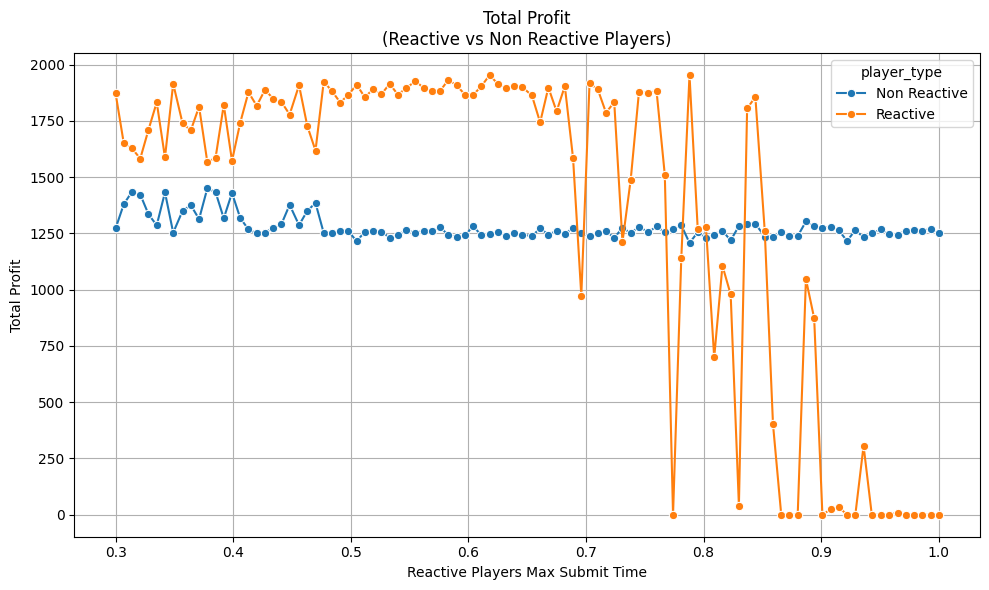

In [4]:
profit_df = pd.concat([
    df[["fast_max_speed", "slow_total_profit"]].rename(columns={"slow_total_profit": "total_profit"}).assign(player_type="Non Reactive"),
    df[["fast_max_speed", "fast_total_profit"]].rename(columns={"fast_total_profit": "total_profit"}).assign(player_type="Reactive")
])

plt.figure(figsize=(10, 6))
sns.lineplot(data=profit_df, x="fast_max_speed", y="total_profit", hue="player_type", marker="o")
plt.title("Total Profit\n(Reactive vs Non Reactive Players)")
plt.xlabel("Reactive Players Max Submit Time")
plt.ylabel("Total Profit")
plt.grid(True)
plt.tight_layout()
plt.savefig("profit_comparison_by_speed.png")
plt.show()


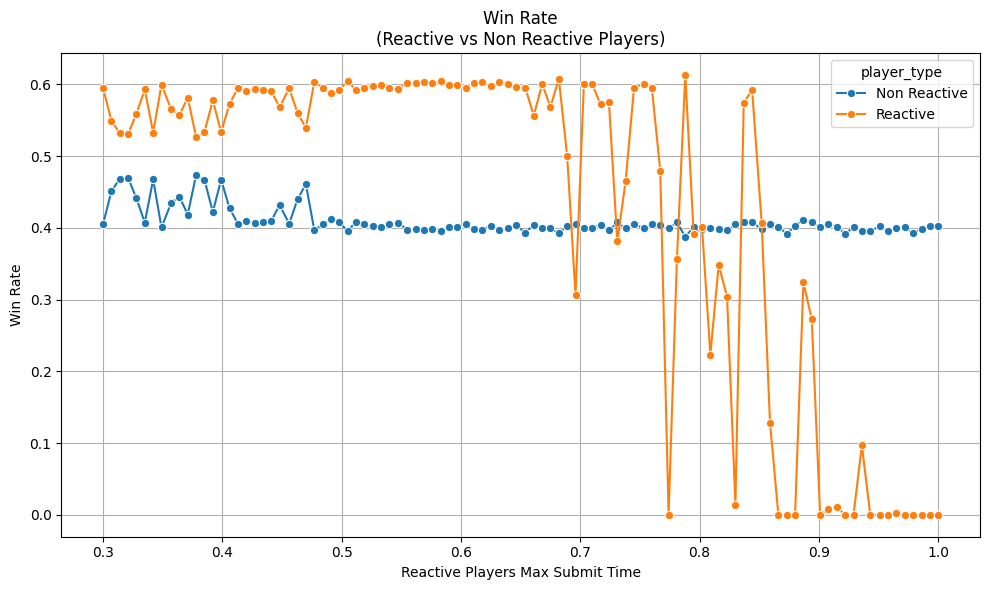

In [5]:
winrate_df = pd.concat([
    df[["fast_max_speed", "slow_win_rate"]].rename(columns={"slow_win_rate": "win_rate"}).assign(player_type="Non Reactive"),
    df[["fast_max_speed", "fast_win_rate"]].rename(columns={"fast_win_rate": "win_rate"}).assign(player_type="Reactive")
])

plt.figure(figsize=(10, 6))
sns.lineplot(data=winrate_df, x="fast_max_speed", y="win_rate", hue="player_type", marker="o")
plt.title("Win Rate\n(Reactive vs Non Reactive Players)")
plt.xlabel("Reactive Players Max Submit Time")
plt.ylabel("Win Rate")
plt.grid(True)
plt.tight_layout()
plt.savefig("winrate_comparison_by_speed.png")
plt.show()


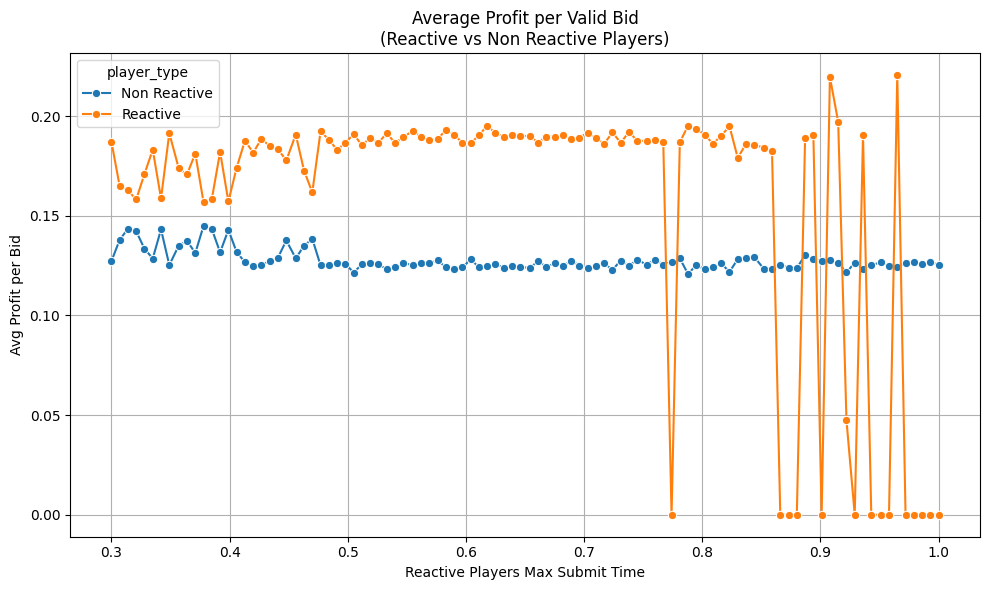

In [6]:
avg_bid_profit_df = pd.concat([
    df[["fast_max_speed", "slow_avg_profit_per_bid"]]
      .rename(columns={"slow_avg_profit_per_bid": "avg_profit_per_bid"})
      .assign(player_type="Non Reactive"),
    
    df[["fast_max_speed", "fast_avg_profit_per_bid"]]
      .rename(columns={"fast_avg_profit_per_bid": "avg_profit_per_bid"})
      .assign(player_type="Reactive")
])

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_bid_profit_df, x="fast_max_speed", y="avg_profit_per_bid", hue="player_type", marker="o")
plt.title("Average Profit per Valid Bid\n(Reactive vs Non Reactive Players)")
plt.xlabel("Reactive Players Max Submit Time")
plt.ylabel("Avg Profit per Bid")
plt.grid(True)
plt.tight_layout()
plt.savefig("avg_profit_per_bid_by_speed.png")
plt.show()


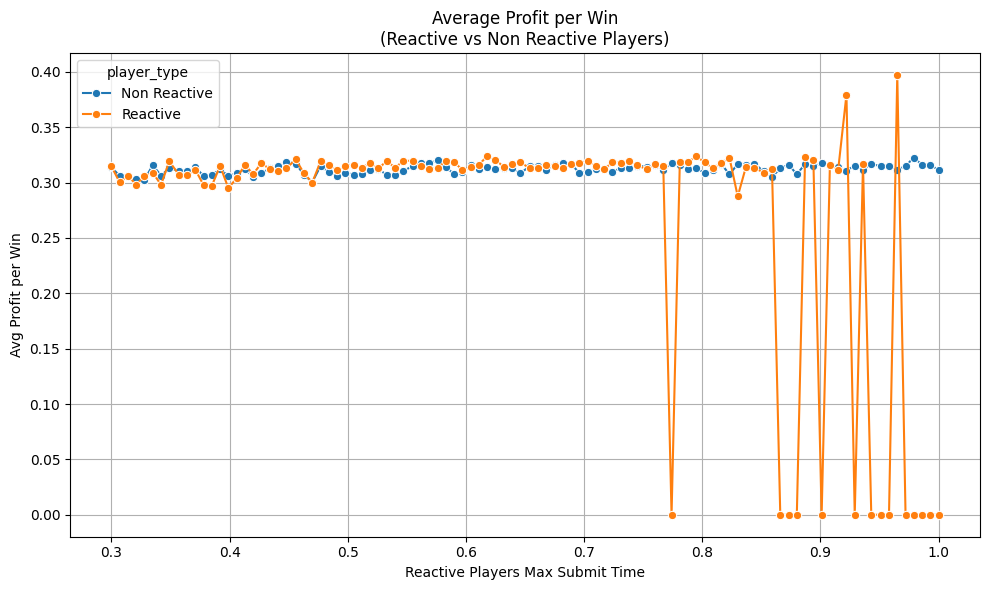

In [7]:
avg_win_profit_df = pd.concat([
    df[["fast_max_speed", "slow_avg_profit_per_win"]]
      .rename(columns={"slow_avg_profit_per_win": "avg_profit_per_win"})
      .assign(player_type="Non Reactive"),
    
    df[["fast_max_speed", "fast_avg_profit_per_win"]]
      .rename(columns={"fast_avg_profit_per_win": "avg_profit_per_win"})
      .assign(player_type="Reactive")
])

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_win_profit_df, x="fast_max_speed", y="avg_profit_per_win", hue="player_type", marker="o")
plt.title("Average Profit per Win\n(Reactive vs Non Reactive Players)")
plt.xlabel("Reactive Players Max Submit Time")
plt.ylabel("Avg Profit per Win")
plt.grid(True)
plt.tight_layout()
plt.savefig("avg_profit_per_win_by_speed.png")
plt.show()


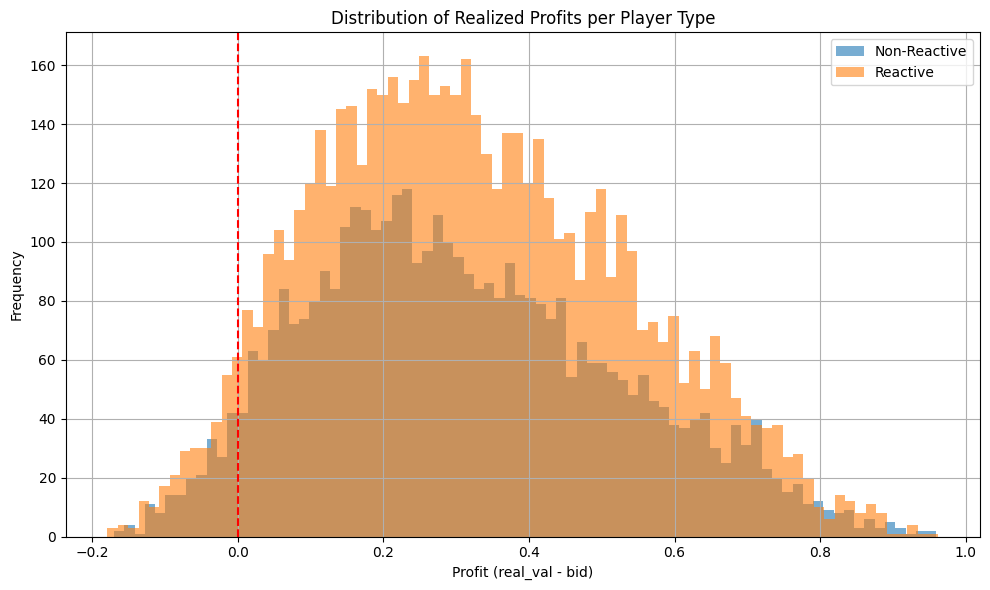

In [8]:
# Step 1: Identify player types
player_type_map = {
    p.player_id: "Reactive" if p.reactive else "Non-Reactive"
    for p in players
}

# Step 2: Extract profits by type
reactive_profits = []
non_reactive_profits = []

for r in round_results:
    if r["winner"]:
        pid, _, profit = r["winner"]
        if player_type_map[pid] == "Reactive":
            reactive_profits.append(profit)
        else:
            non_reactive_profits.append(profit)

# Step 3: Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(non_reactive_profits, bins=80, alpha=0.6, label="Non-Reactive")
plt.hist(reactive_profits, bins=80, alpha=0.6, label="Reactive")
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Realized Profits per Player Type")
plt.xlabel("Profit (real_val - bid)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
